# 다음에 볼 영화 예측하기[프로젝트]

### 필요한 라이브러리 import

In [1]:
import datetime as dt
from pathlib import Path
import os
import time
from datetime import datetime
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### 데이터셋 로드
- 이전의 SessionID의 역할을 UserID가 해줘야 함
- Rating 정보 포함
  - 직전 영화가 마음에 들었는지 -> 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수 있음
  - Rating이 낮은 데이터를 어떻게 처리할지도 고민
- Time : UTC Time 정보 포함
  - 1970년 1월 1일부터 경과된 초 단위 시간 기재

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


<br>
<br>
<br>

### Step 1. 데이터의 전처리

- ItemId 분포 확인하기
  - 중간에 튀는 count가 있기는 하나, 전체적으로 고른 편

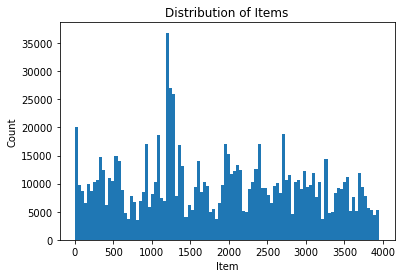

In [5]:
plt.hist(data['ItemId'], bins=100)
plt.title("Distribution of Items")
plt.xlabel('Item')
plt.ylabel('Count')
plt.show()

- Time 분포 확인하기
  - 2000년 5월 ~ 2021년 1월까지의 사용량이 가장 많음
  - 그러나, 사용량이 줄어든 것을 제외하기보다는 적은 양이지만 포함하는 것으로 우선 시도

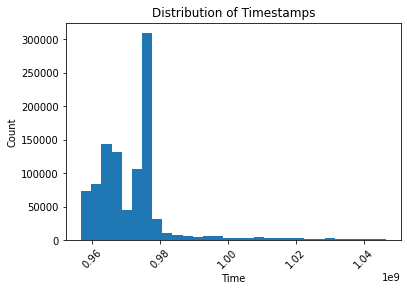

In [6]:
plt.hist(data['Time'], bins=30)
plt.title("Distribution of Timestamps")
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

- UTC timestamp를 datetime으로 변환하여 사용

In [3]:
data['Time'] = pd.to_datetime(data['Time'], unit='s')
data.sort_values(['UserId', 'Time'], inplace=True)

- 세션 구성을 보았을 때 30분이 지나면 -> 새로운 세션으로 구분할 수 있도록 초기 설정해보기
  - Google Analytics의 경우, 30분을 기준으로 세션을 분리하기 때문에 이에 따라 초기는 30분으로 설정하는 것으로 먼저 생각

In [4]:
SESSION_THRESHOLD = pd.Timedelta(minutes=30)

data['SessionId'] = (
    data.groupby('UserId')['Time']
    .apply(lambda x: (x.diff() > SESSION_THRESHOLD).cumsum())
)

data

,UserId,ItemId,Rating,Time,SessionId
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,0
27,1,1721,4,2000-12-31 22:00:55,0
37,1,1022,5,2000-12-31 22:00:55,0
24,1,2340,3,2000-12-31 22:01:43,0
...,...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29,7
999988,6040,1921,4,2001-08-10 14:41:04,7
1000172,6040,1784,3,2001-08-10 14:41:04,7
1000167,6040,161,3,2001-08-10 14:41:26,7


<br>

- 세션 분포 확인

In [9]:
data['SessionId'].value_counts()

0      606773
1      168432
2       75115
3       35396
4       23968
        ...  
289         1
288         1
287         1
286         1
267         1
Name: SessionId, Length: 354, dtype: int64

- 다만, 30분으로 설정을 해도 될지에 대한 여부를 추가 분석해봄
  - 30분을 넘어가는 경우는 19123 정도로 다소 작기 때문에 세션을 30분으로 초기 설정해도 무방할 것으로 파악

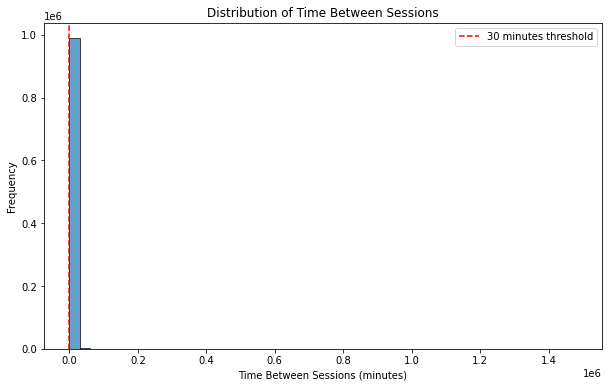

Sessions with time difference <= 30 minutes: 975046
Sessions with time difference > 30 minutes: 19123


In [5]:
# 같은 유저 사이에서의 시간 차이 계산
data['Time'] = pd.to_datetime(data['Time'])
data['Time_diff'] = data.groupby('UserId')['Time'].diff()

time_diff_counts = data['Time_diff'].dt.total_seconds() / 60

# 30분 이하와 초과한 경우 구분
less_than_30min = time_diff_counts[time_diff_counts <= 30]
greater_than_30min = time_diff_counts[time_diff_counts > 30]

# 시간 차이 분포 시각화
plt.figure(figsize=(10, 6))
plt.hist(time_diff_counts, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=30, color='red', linestyle='--', label="30 minutes threshold")
plt.title('Distribution of Time Between Sessions')
plt.xlabel('Time Between Sessions (minutes)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# 30분 이하와 초과한 경우의 빈도
print(f"Sessions with time difference <= 30 minutes: {len(less_than_30min)}")
print(f"Sessions with time difference > 30 minutes: {len(greater_than_30min)}")

> 데이터에서 의심스러운 부분
- 하나의 UserId가 정확히 같은 시간에 여러 아이템을 조회하는 것이 가능한지 여부
  - 대부분의 유저가 이에 해당되기 때문에, 어떻게 해석해서 처리해야할 지에 대해서 고민이 필요해 보임
  - Time 기록 자체를 배치 처리하여 이러한 현상이 발생했을 수도 있고, 밀리초 이하 시간 차이를 무시하게 되어 발생한 문제로도 추축해볼 수 있음
  - 그게 아니라면, 추천 시스템 자체가 여러 개의 아이템을 동시에 보여주는 경우가 많고, 추천 목록을 스크롤하며 확인하게 될 경우 동시에 기록되는 것이 가능하기 때문에 이러한 데이터가 주로 저장되어 있는 것으로 판단


<br>

- Rating이 낮은 데이터 처리
  - 기존의 클릭 기반 분석이 아닌 Rating을 이용한 분석 필요
  - 최소, 최댓값, 개수까지 확인하여 최소 개수 설정 시도

In [11]:
data['Rating'].value_counts()

4    348971
3    261197
5    226310
2    107557
1     56174
Name: Rating, dtype: int64

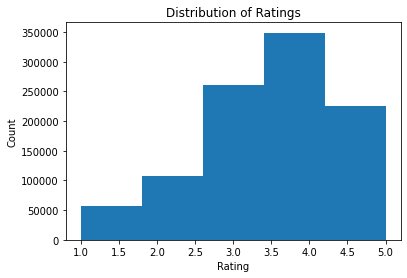

In [12]:
plt.hist(data['Rating'], bins=5)
plt.title("Distribution of Ratings")
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [13]:
min_rating = data["Rating"].min()
max_rating = data["Rating"].max()

print(f"Rating 최솟값 ({min_rating}) 개수:", (data["Rating"] == min_rating).sum())
print(f"Rating 최댓값 ({max_rating}) 개수:", (data["Rating"] == max_rating).sum())

Rating 최솟값 (1) 개수: 56174
Rating 최댓값 (5) 개수: 226310


In [14]:
print(data["Rating"].value_counts().sort_index())

1     56174
2    107557
3    261197
4    348971
5    226310
Name: Rating, dtype: int64


- 평점 1과 2의 경우, 다른 평점에 비해 개수가 적은 편에 속해 제거해도 무방할 것으로 판단

In [6]:
MIN_RATING = 2
filtered_data = data[data['Rating'] >= MIN_RATING]

<br>

- 세션 길이 분석

In [8]:
session_lengths = filtered_data.groupby('SessionId').size()
session_lengths.describe()

count       351.000000
mean       2689.558405
std       32032.626937
min           1.000000
25%           1.000000
50%           8.000000
75%          36.500000
max      573965.000000
dtype: float64

<br>

- 2개 이하의 아이템을 본 세션의 경우, 사용자가 선호하지 않은 상태로 무작위 접속했을 가능성이 있고. 다음 행동을 예측하는데에 큰 도움이 되지 않을 것으로 판단하여 제거

In [9]:
MIN_SESSION_LENGTH = 2
filtered_data = filtered_data[filtered_data['SessionId'].isin(session_lengths[session_lengths >= MIN_SESSION_LENGTH].index)]

<br>

- 최종 filtered_data 확인

In [18]:
filtered_data

,UserId,ItemId,Rating,Time,SessionId,Time_diff
31,1,3186,4,2000-12-31 22:00:19,0,NaT
22,1,1270,5,2000-12-31 22:00:55,0,0 days 00:00:36
27,1,1721,4,2000-12-31 22:00:55,0,0 days 00:00:00
37,1,1022,5,2000-12-31 22:00:55,0,0 days 00:00:00
24,1,2340,3,2000-12-31 22:01:43,0,0 days 00:00:48
...,...,...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29,7,0 days 00:00:31
999988,6040,1921,4,2001-08-10 14:41:04,7,0 days 00:00:35
1000172,6040,1784,3,2001-08-10 14:41:04,7,0 days 00:00:00
1000167,6040,161,3,2001-08-10 14:41:26,7,0 days 00:00:22


<br>
<br>
<br>

### Step 2. 미니 배치의 구성
- 데이터 전처리 과정을 통해 `SessionId`를 생성했기 때문에, 이를 활용하는 방식으로 진행
  - 추후, 성능이 잘 나오지 않을 경우, `UserId` 기반으로 변경 시도 예정

In [19]:
# 세션 데이터를 미니 배치로 나누기
def generate_mini_batches(filtered_data, batch_size):
    sessions = filtered_data['SessionId'].unique()
    np.random.shuffle(sessions)
    
    for i in range(0, len(sessions), batch_size):
        batch_sessions = sessions[i:i + batch_size]
        yield filtered_data[filtered_data['SessionId'].isin(batch_sessions)]

# 미니 배치 생성 테스트
batch_size = 64
for mini_batch in generate_mini_batches(filtered_data, batch_size):
    print(f"Mini batch size: {len(mini_batch)}")
    break

Mini batch size: 6109


In [ ]:
# # UserId를 사용하고자 할 경우
# mini_batches = []

# for user_id, group in filtered_data.groupby('UserId'):
#     batch = group[['ItemId', 'Rating']].values
#     mini_batches.append(batch)

<br>
<br>
<br>

### Step 3. 모델 구성
- GRU4Rec 사용(RNN 기반 모델)
  - 모델을 변경하는 시도를 할 경우, SASRec 모델 or LSTM4Rec 적용 예정
    - 다만 SASRec 모델은 RNN 기반 모델이 아니기 때문에 `GRU4Rec ➡️ LSTM4Rec ➡️ SASRec` 순서로 변경 적용 시도할 예정
    - 참고 : [kt NexR 기술블로그_[18] 딥러닝 기반 추천 시스템: kt NexR 기술 블로그 '21 테크리포트](https://tech.nexr.kr/771417b9-e1a0-4c79-8555-0f578c482c25)

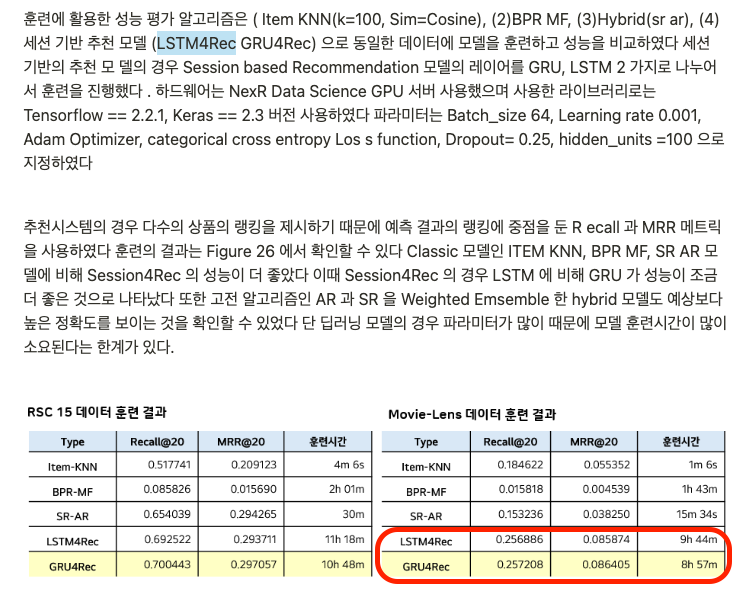

<br>

#### GRU4Rec 구성
- 고유 아이템 수의 경우, 인덱스가 0부터 시작되는 것을 고려하여 +1 수행
- `hidden_size`는 128로 초기 설정
- 출력 크기는 아이템 수와 동일하게 설정

In [14]:
import torch
import torch.nn as nn

class GRU4Rec(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU4Rec, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.gru(x)
        output = self.fc(output)
        return output

# 모델 초기화
input_size = filtered_data['ItemId'].nunique() + 1
hidden_size = 128
output_size = input_size

model = GRU4Rec(input_size, hidden_size, output_size)

model

GRU4Rec(
  (embedding): Embedding(3676, 128)
  (gru): GRU(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=3676, bias=True)
)

<br>
<br>
<br>

### Step 4. 모델 학습
- 초기 하이퍼파라미터 설정 후, 실험을 통해 변경하기

In [15]:
learning_rate = 0.001
epochs = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
batch_size = 64

- filtered_data에서 train_data 쪼개기

In [84]:
train_data = filtered_data[['SessionId', 'ItemId']].groupby('SessionId')['ItemId'].apply(list)

- epoch, loss 설정해 학습 진행

In [18]:
for epoch in range(epochs):
    total_loss = 0
    for session in train_data:
        for i in range(0, len(session) - 1, batch_size):
            batch_session = session[i:i + batch_size]
            inputs = torch.tensor(batch_session[:-1]).unsqueeze(0)  # 마지막 아이템 제외
            targets = torch.tensor(batch_session[1:]).unsqueeze(0)  # 첫 번째 아이템 제외

            # 아이템 ID가 Embedding 층의 범위를 벗어나지 않게 체크(IndexError 방지)
            inputs = torch.clamp(inputs, 0, input_size - 1)
            targets = torch.clamp(targets, 0, input_size - 1)
            outputs = model(inputs)
            loss = loss_fn(outputs.view(-1, output_size), targets.view(-1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss}")

Epoch 1/10, Loss: 89107.96316075325
Epoch 2/10, Loss: 82709.32528591156
Epoch 3/10, Loss: 80924.81061577797
Epoch 4/10, Loss: 79862.96364831924
Epoch 5/10, Loss: 79119.63238668442
Epoch 6/10, Loss: 78557.52835571766
Epoch 7/10, Loss: 78108.93370461464
Epoch 8/10, Loss: 77750.60621845722
Epoch 9/10, Loss: 77455.04295873642
Epoch 10/10, Loss: 77223.18368005753


- Loss값이 다소 크게 나옴 ➡️ 학습률이 다소 크지 않을까 추측됨, 따라서 학습률을 낮추기 위해 옵티마이저를 1e-4정도로 줄여보는 시도를 할 수 있을 것으로 보임
  - 우선, 모델 테스트부터 진행

<br>
<br>
<br>

### Step 5. 모델 테스트(1)
- 데이터에서 별도로 검증 데이터를 분리하지 않고, 테스트 데이터로 평가할 예정!

In [21]:
# 평가 지표 계산 (Recall@K, MRR@K)
def recall_mrr_k(model, test_data, k=20):
    recalls = []
    mrrs = []
    for session in test_data:
        inputs = torch.tensor(session[:-1]).unsqueeze(0)
        targets = session[1:]

        # 아이템 ID가 Embedding 층의 범위를 벗어나지 않게 처리
        inputs = torch.clamp(inputs, 0, input_size - 1)
        
        outputs = model(inputs).squeeze(0).detach().numpy()
        top_k = np.argsort(outputs, axis=1)[:, -k:]

        for i, target in enumerate(targets):
            if target in top_k[i]:
                recalls.append(1)
                rank = np.where(top_k[i] == target)[0][0] + 1
                mrrs.append(1 / rank)
            else:
                recalls.append(0)
                mrrs.append(0)

    return np.mean(recalls), np.mean(mrrs)

In [22]:
# 테스트 데이터로 평가
test_data = train_data.sample(frac=0.2)
recall, mrr = recall_mrr_k(model, test_data)
print(f"Recall@20: {recall:.4f}, MRR@20: {mrr:.4f}")

Recall@20: 0.3607, MRR@20: 0.0448


#### 1차 모델링 결과
- `Recall@20`이 약 36% 정도로 나왔고, 아주 낮지는 않지만 높다고 볼 수 없는 성능임.
- `MRR@20`의 경우, 평균적인 수치를 낸 것으로 판단.

<br>
<br>
<br>

### Step 5. 모델 테스트(2)
#### 세션 기준 변경 및 하이퍼파라미터 변경 후 재시도
- 세션 기준을 1시간으로 변경해보기

In [85]:
SESSION_THRESHOLD = pd.Timedelta(minutes=60)

In [24]:
# learning_rate = 0.0005
epochs = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # lr 줄이기
batch_size = 64
dropout_rate = 0.2 # 드롭아웃 적용

In [20]:
train_data = filtered_data[['SessionId', 'ItemId']].groupby('SessionId')['ItemId'].apply(list)

In [26]:
for epoch in range(epochs):
    total_loss = 0
    for session in train_data:
        for i in range(0, len(session) - 1, batch_size):
            batch_session = session[i:i + batch_size]
            inputs = torch.tensor(batch_session[:-1]).unsqueeze(0)  # 마지막 아이템 제외
            targets = torch.tensor(batch_session[1:]).unsqueeze(0)  # 첫 번째 아이템 제외

            # 아이템 ID가 Embedding 층의 범위를 벗어나지 않게 체크(IndexError 방지)
            inputs = torch.clamp(inputs, 0, input_size - 1)
            targets = torch.clamp(targets, 0, input_size - 1)
            outputs = model(inputs)
            loss = loss_fn(outputs.view(-1, output_size), targets.view(-1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss}")

Epoch 1/10, Loss: 75599.8981936872
Epoch 2/10, Loss: 74279.6155655384
Epoch 3/10, Loss: 73859.07812801003
Epoch 4/10, Loss: 73594.73442906141
Epoch 5/10, Loss: 73395.75992369652
Epoch 6/10, Loss: 73229.43417394161
Epoch 7/10, Loss: 73086.51083016396
Epoch 8/10, Loss: 72956.94933849573
Epoch 9/10, Loss: 72840.42700362206
Epoch 10/10, Loss: 72729.29730373621


In [34]:
# 평가 지표 계산 (Recall@K, MRR@K)
def recall_mrr_k(model, test_data, k=20):
    recalls = []
    mrrs = []
    for session in test_data:
        inputs = torch.tensor(session[:-1]).unsqueeze(0)
        targets = session[1:]

        # 아이템 ID가 Embedding 층의 범위를 벗어나지 않게 처리
        inputs = torch.clamp(inputs, 0, input_size - 1)
        
        outputs = model(inputs).squeeze(0).detach().numpy()
        top_k = np.argsort(outputs, axis=1)[:, -k:]

        for i, target in enumerate(targets):
            if target in top_k[i]:
                recalls.append(1)
                rank = np.where(top_k[i] == target)[0][0] + 1
                mrrs.append(1 / rank)
            else:
                recalls.append(0)
                mrrs.append(0)

    return np.mean(recalls), np.mean(mrrs)

# 테스트 데이터로 평가
test_data = train_data.sample(frac=0.2)
recall, mrr = recall_mrr_k(model, test_data)
print(f"Recall@20: {recall:.4f}, MRR@20: {mrr:.4f}")

Recall@20: 0.3999, MRR@20: 0.0469


<br>
<br>
<br>

### Step 5. 모델 테스트(3)
- 모델 변경 : `GRU4Rec` ➡️ `LSTM4Rec`
  - 하이퍼파라미터는 동일한 파라미터는 2번과 동일하게 고정하고, 모델에 따라 추가되는 파라미터는 별도로 추가

In [88]:
import torch
import torch.nn as nn

class LSTM4Rec(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, dropout_rate=0.2, num_layers=1):
        super(LSTM4Rec, self).__init__()

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout_rate)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.embedding(x)
        x, (hn, cn) = self.lstm(x)
        x = self.dropout(x)
        x = self.fc(x)  # 시퀀스 전체에 대해 예측을 수행 (배치 크기, 시퀀스 길이, 출력 크기)
        return x

In [89]:
vocab = sorted(set(data['ItemId'].values))

In [90]:
model = LSTM4Rec(input_size, embedding_size, hidden_size, output_size, dropout_rate, num_layers)

In [91]:
epochs = 10
input_size = len(vocab)  # 아이템의 수 (vocab 크기)
output_size = len(vocab)  # 출력 크기 (아이템 수)

embedding_size = 128
hidden_size = 128
batch_size = 64

dropout_rate = 0.2
num_layers = 1  # LSTM 레이어 수
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [27]:
# # 손실 함수
# loss_fn = nn.CrossEntropyLoss()

# # 학습
# for epoch in range(epochs):
#     total_loss = 0
#     for session in train_data:
#         for i in range(0, len(session) - 1, batch_size):
#             batch_session = session[i:i + batch_size]
#             inputs = torch.tensor(batch_session[:-1])
#             targets = torch.tensor(batch_session[1:])

#             # 아이템 ID가 Embedding layer 범위 내에 있도록 조정(IndexError 방지)
#             inputs = torch.clamp(inputs, 0, input_size - 1)
#             targets = torch.clamp(targets, 0, input_size - 1)

#             # LSTM 입력에 맞게 차원 맞추기
#             inputs = inputs.unsqueeze(0)
#             targets = targets.unsqueeze(0)

#             outputs = model(inputs)

#             outputs = outputs.view(-1, output_size)
#             targets = targets.view(-1)

#             loss = loss_fn(outputs, targets)

#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             total_loss += loss.item()

#     print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss}")

Epoch 1/10, Loss: 105693.45828819275
Epoch 2/10, Loss: 96765.48223376274
Epoch 3/10, Loss: 92241.21271586418
Epoch 4/10, Loss: 89728.75692796707
Epoch 5/10, Loss: 88064.23286986351
Epoch 6/10, Loss: 86876.81271195412
Epoch 7/10, Loss: 85950.3028459549
Epoch 8/10, Loss: 85198.7843079567
Epoch 9/10, Loss: 84588.54621386528
Epoch 10/10, Loss: 84065.55984950066


In [93]:
# 커널 이슈로 재실행
# 손실 함수
loss_fn = nn.CrossEntropyLoss()

# 학습
for epoch in range(epochs):
    total_loss = 0
    for session in train_data:
        for i in range(0, len(session) - 1, batch_size):
            batch_session = session[i:i + batch_size]
            inputs = torch.tensor(batch_session[:-1])
            targets = torch.tensor(batch_session[1:])

            # 아이템 ID가 Embedding layer 범위 내에 있도록 조정(IndexError 방지)
            inputs = torch.clamp(inputs, 0, input_size - 1)
            targets = torch.clamp(targets, 0, input_size - 1)

            # LSTM 입력에 맞게 차원 맞추기
            inputs = inputs.unsqueeze(0)
            targets = targets.unsqueeze(0)

            outputs = model(inputs)

            outputs = outputs.view(-1, output_size)
            targets = targets.view(-1)

            loss = loss_fn(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss}")

Epoch 1/10, Loss: 87926.24275875092
Epoch 2/10, Loss: 86820.9829890728
Epoch 3/10, Loss: 85924.01674580574
Epoch 4/10, Loss: 85189.65595126152
Epoch 5/10, Loss: 84559.53745746613
Epoch 6/10, Loss: 84053.89250636101
Epoch 7/10, Loss: 83605.34282183647
Epoch 8/10, Loss: 83224.61079335213
Epoch 9/10, Loss: 82857.94791293144
Epoch 10/10, Loss: 82548.3940346241


- 메모리 초과 이슈
  - 배치 unsqueeze를 0으로 지정, 모델에 맞게 불필요한 코드 삭제하여 재실행

In [97]:
# 평가 지표 계산 (Recall@K, MRR@K)
def recall_mrr_k(model, test_data, k=20):
    recalls = []
    mrrs = []
    for session in test_data:
        # 세션을 모델에 맞게 처리
        inputs = torch.tensor(session[:-1]).unsqueeze(0)  # Add batch and time dimension
        targets = session[1:]

        # 아이템 ID가 Embedding 층의 범위를 벗어나지 않게 처리
        inputs = torch.clamp(inputs, 0, input_size - 1)
        
        # 모델 출력 계산
        outputs = model(inputs).squeeze(0).detach().numpy()

        # Top-k 예측 값 추출 (NumPy를 사용한 효율적인 연산)
        top_k = np.argsort(outputs)[-k:]

        for i, target in enumerate(targets):
            if target in top_k:
                recalls.append(1)
                rank = np.where(top_k == target)[0][0] + 1
                mrrs.append(1 / rank)
            else:
                recalls.append(0)
                mrrs.append(0)

    return np.mean(recalls), np.mean(mrrs)

- 실행 시, 커널이 중지되는 이슈가 있어 추후 해결할 예정😅

In [ ]:
# 테스트 데이터로 평가
test_data = train_data.sample(frac=0.2)
test_data_list = test_data.tolist()
recall, mrr = recall_mrr_k(model, test_data_list)
print(f"Recall@20: {recall:.4f}, MRR@20: {mrr:.4f}")

<br>
<br>
<br>

### Step 5. 모델 테스트(4)
- 모델 : `GRU4Rec` 이용
- 드롭아웃을 0.2에서 0.1로 감소시키기
- learning_rate를 동적으로 조정하는 방식을 적용
  - `torch.optim.lr_scheduler`

In [21]:
SESSION_THRESHOLD = pd.Timedelta(minutes=60)

In [23]:
import torch
import torch.nn as nn

class GRU4Rec(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU4Rec, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.gru(x)
        output = self.fc(output)
        return output

# 모델 초기화
input_size = filtered_data['ItemId'].nunique() + 1
hidden_size = 128
output_size = input_size

model = GRU4Rec(input_size, hidden_size, output_size)

model

GRU4Rec(
  (embedding): Embedding(3676, 128)
  (gru): GRU(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=3676, bias=True)
)

In [27]:
epochs = 10
loss_fn = nn.CrossEntropyLoss()
batch_size = 64
dropout_rate = 0.1 # 드롭아웃 적용

learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # lr 줄이기
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

In [30]:
train_data = filtered_data[['SessionId', 'ItemId']].groupby('SessionId')['ItemId'].apply(list)

In [30]:
for epoch in range(epochs):
    total_loss = 0
    for session in train_data:
        for i in range(0, len(session) - 1, batch_size):
            batch_session = session[i:i + batch_size]
            inputs = torch.tensor(batch_session[:-1]).unsqueeze(0)  # 마지막 아이템 제외
            targets = torch.tensor(batch_session[1:]).unsqueeze(0)  # 첫 번째 아이템 제외

            # 아이템 ID가 Embedding 층의 범위를 벗어나지 않게 체크(IndexError 방지)
            inputs = torch.clamp(inputs, 0, input_size - 1)
            targets = torch.clamp(targets, 0, input_size - 1)
            
            # inputs = inputs.unsqueeze(2)
            targets = targets.squeeze(0).view(-1)
            
            outputs = model(inputs)
            loss = loss_fn(outputs.view(-1, output_size), targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
    
    scheduler.step(total_loss)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss}")

Epoch 1/10, Loss: 104159.39842271805
Epoch 2/10, Loss: 94633.57082772255
Epoch 3/10, Loss: 90191.1409676075
Epoch 4/10, Loss: 87655.85948181152
Epoch 5/10, Loss: 85975.47580695152
Epoch 6/10, Loss: 84753.35161876678
Epoch 7/10, Loss: 83802.76826190948
Epoch 8/10, Loss: 83030.18741965294
Epoch 9/10, Loss: 82380.90259933472
Epoch 10/10, Loss: 81820.9533610344


In [31]:
# 평가 지표 계산 (Recall@K, MRR@K)
def recall_mrr_k(model, test_data, k=20):
    recalls = []
    mrrs = []
    for session in test_data:
        inputs = torch.tensor(session[:-1]).unsqueeze(0)
        targets = session[1:]

        # 아이템 ID가 Embedding 층의 범위를 벗어나지 않게 처리
        inputs = torch.clamp(inputs, 0, input_size - 1)
        
        outputs = model(inputs).squeeze(0).detach().numpy()
        top_k = np.argsort(outputs, axis=1)[:, -k:]

        for i, target in enumerate(targets):
            if target in top_k[i]:
                recalls.append(1)
                rank = np.where(top_k[i] == target)[0][0] + 1
                mrrs.append(1 / rank)
            else:
                recalls.append(0)
                mrrs.append(0)

    return np.mean(recalls), np.mean(mrrs)

In [32]:
# 테스트 데이터로 평가
test_data = train_data.sample(frac=0.2)
recall, mrr = recall_mrr_k(model, test_data)
print(f"Recall@20: {recall:.4f}, MRR@20: {mrr:.4f}")

Recall@20: 0.2417, MRR@20: 0.0328


<br>
<br>
<br>

#### 번외) 데이터 전처리 추가_일부 데이터만을 이용해 빠르게 학습 + 코드 리팩토링(함수화)
- Time 컬럼에서 2000년 5월 ~ 2021년 1월까지의 데이터만 사용
- ItemId의 이상치 제거: count가 30000이상인 데이터 삭제
- 세션은 30분으로 설정
- GRU4Rec 모델 사용
- 미니 배치 사용
```python
# 세션 데이터를 미니 배치로 나누기
def generate_mini_batches(filtered_data, batch_size):
    sessions = filtered_data['SessionId'].unique()
    np.random.shuffle(sessions)
    
    for i in range(0, len(sessions), batch_size):
        batch_sessions = sessions[i:i + batch_size]
        yield filtered_data[filtered_data['SessionId'].isin(batch_sessions)]
# 미니 배치 생성 테스트
batch_size = 64
for mini_batch in generate_mini_batches(filtered_data, batch_size):
    print(f"Mini batch size: {len(mini_batch)}")
    break
```

In [10]:
# 2000년 5월 ~ 2021년 1월 사이의 데이터만 필터링
filtered_data = filtered_data[(filtered_data['Time'] >= '2000-05-01') & (filtered_data['Time'] <= '2021-01-31')]

In [11]:
# 각 ItemId의 등장 횟수를 계산
item_counts = filtered_data['ItemId'].value_counts()

# 등장 횟수가 30000 이상인 ItemId를 필터링
valid_item_ids = item_counts[item_counts < 30000].index
filtered_data = filtered_data[filtered_data['ItemId'].isin(valid_item_ids)]

In [12]:
# 세션 데이터에 대해 Time을 기준으로 그룹화하고 30분 간격으로 나누기
filtered_data['Time_diff'] = filtered_data.groupby('SessionId')['Time'].diff().fillna(pd.Timedelta(seconds=0))
filtered_data['New_SessionId'] = (filtered_data['Time_diff'] > pd.Timedelta(minutes=30)).cumsum() + 1

# 새로운 세션 ID로 데이터 그룹화
filtered_data['SessionId'] = filtered_data['New_SessionId']
filtered_data = filtered_data.drop(columns=['Time_diff', 'New_SessionId'])

In [13]:
filtered_data

,UserId,ItemId,Rating,Time,SessionId
31,1,3186,4,2000-12-31 22:00:19,1
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,1
37,1,1022,5,2000-12-31 22:00:55,1
24,1,2340,3,2000-12-31 22:01:43,1
...,...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29,9171
999988,6040,1921,4,2001-08-10 14:41:04,9171
1000172,6040,1784,3,2001-08-10 14:41:04,9171
1000167,6040,161,3,2001-08-10 14:41:26,9171


In [14]:
# 미니 배치 생성 함수
def generate_mini_batches(filtered_data, batch_size):
    sessions = filtered_data['SessionId'].unique()
    np.random.shuffle(sessions)

    for i in range(0, len(sessions), batch_size):
        batch_sessions = sessions[i:i + batch_size]
        yield filtered_data[filtered_data['SessionId'].isin(batch_sessions)]

# 미니 배치 생성 테스트
batch_size = 64
for mini_batch in generate_mini_batches(filtered_data, batch_size):
    print(f"Mini batch size: {len(mini_batch)}")
    break

Mini batch size: 5896


In [21]:
epochs = 10
batch_size = 64
embedding_size = 50
hidden_size = 128
learning_rate = 1e-4
output_size = input_size

In [23]:
import torch
import torch.nn as nn

class GRU4Rec(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, dropout_rate=0.1):
        super(GRU4Rec, self).__init__()
        
        # Embedding Layer
        self.embedding = nn.Embedding(input_size, embedding_size)
        
        # GRU Layer
        self.gru = nn.GRU(embedding_size, hidden_size, batch_first=True, dropout=dropout_rate)
        
        # Fully Connected Layer
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # x: [batch_size, sequence_length]
        x = self.embedding(x)
        output, _ = self.gru(x)
        output = self.fc(output[:, -1, :])  # 마지막 시퀀스만 쓰기
        return output

In [24]:
model = GRU4Rec(input_size=input_size, embedding_size=embedding_size, hidden_size=hidden_size, output_size=output_size)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [27]:
def train(model, train_data, optimizer, loss_fn, batch_size, input_size, output_size, epochs):
    for epoch in range(epochs):
        total_loss = 0
        for session in train_data:
            for i in range(0, len(session) - 1, batch_size):
                batch_session = session[i:i + batch_size]

                # 배치 크기가 batch_size보다 작은 경우를 처리
                if len(batch_session) < batch_size:
                    continue  # 배치 크기가 작으면 해당 배치를 건너뜁니다.

                inputs = torch.tensor(batch_session[:-1])  # 마지막 아이템 제외
                targets = torch.tensor(batch_session[1:])  # 첫 번째 아이템 제외

                # 아이템 ID가 Embedding 층의 범위를 벗어나지 않게 체크(IndexError 방지)
                inputs = torch.clamp(inputs, 0, input_size - 1)
                targets = torch.clamp(targets, 0, input_size - 1)

                # 배치 차원 추가
                batch_size_actual = len(batch_session) - 1  # 실제 배치 크기
                inputs = inputs.view(batch_size_actual, -1)  # 실제 배치 크기에 맞게 뷰 수정
                targets = targets.view(-1)  # 타겟은 1차원 벡터로 변환

                # 모델 출력은 (batch_size, sequence_length, output_size) 형태
                outputs = model(inputs)

                # outputs를 (batch_size * sequence_length, output_size) 형태로 reshape
                outputs = outputs.view(-1, output_size)

                # 손실 계산
                loss = loss_fn(outputs, targets)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

        # Epoch마다 출력
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

In [28]:
# 성능 평가를 수행하는 함수
def evaluate(model, test_data, k=20):
    recall, mrr = recall_mrr_k(model, test_data, k)  # Recall@k, MRR@k 계산
    return recall, mrr

In [31]:
# 학습을 시작하는 부분
train(model, train_data, optimizer, loss_fn, batch_size, input_size, output_size, epochs)

Epoch 1/10, Loss: 92102.7699
Epoch 2/10, Loss: 88855.4000
Epoch 3/10, Loss: 86167.9288
Epoch 4/10, Loss: 84127.9231
Epoch 5/10, Loss: 82708.3322
Epoch 6/10, Loss: 81661.1278
Epoch 7/10, Loss: 80853.2084
Epoch 8/10, Loss: 80207.3839
Epoch 9/10, Loss: 79675.4203
Epoch 10/10, Loss: 79226.3202


In [33]:
import torch
import numpy as np

def recall_mrr_k(model, test_data, k=20):
    recall = 0.0
    mrr = 0.0
    num_samples = len(test_data)
    
    # 임베딩 크기 확인 (가장 큰 인덱스를 구함)
    max_index = model.embedding.num_embeddings - 1
    
    for session in test_data:
        inputs = torch.tensor(session[:-1], dtype=torch.long)  # dtype 추가
        targets = torch.tensor(session[1:], dtype=torch.long)  # dtype 추가

        # 인덱스를 임베딩 범위 내로 클리핑
        max_index = model.embedding.num_embeddings - 1
        inputs = torch.clamp(inputs, 0, max_index)
        inputs = inputs.unsqueeze(-1)

        outputs = model(inputs).squeeze(0).detach().numpy()

        if len(outputs.shape) == 1:
            outputs = outputs.reshape(1, -1)

        top_k = np.argsort(outputs, axis=1)[:, -k:]

        for i, target in enumerate(targets):
            target_idx = np.where(top_k[i] == target.item())[0]
            if len(target_idx) > 0:
                recall += 1.0
                mrr += 1.0 / (target_idx[0] + 1)

    recall /= num_samples
    mrr /= num_samples
    
    return recall, mrr

# 테스트 데이터로 평가
test_data = train_data.sample(frac=0.2)
recall, mrr = recall_mrr_k(model, test_data)
print(f"Recall@20: {recall:.4f}, MRR@20: {mrr:.4f}")

Recall@20: 20.6930, MRR@20: 2.5885


<br>
<br>
<br>

- 그리드서치, 랜덤 서치의 경우 시간이 오래 걸려, Optuna로 빠르게 하이퍼파라미터 튜닝 시도

In [35]:
!pip install optuna

     |████████████████████████████████| 383 kB 4.5 MB/s            
     |████████████████████████████████| 3.1 MB 92.4 MB/s            
     |████████████████████████████████| 233 kB 70.1 MB/s            
     |████████████████████████████████| 78 kB 12.9 MB/s            
     |████████████████████████████████| 597 kB 64.8 MB/s            
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.0.1
    Uninstalling typing-extensions-4.0.1:
      Successfully uninstalled typing-extensions-4.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-gpu 2.6.0 requires numpy~=1.19.2, but you have numpy 1.21.4 which is incompatible.
tensorflow-gpu 2.6.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow-gpu 2.6.0 requires typing-extensions~=3.7.4, but you have typing-extensions 4.12.2 which is

In [36]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim

# GRU4Rec 모델 정의 (기존에 사용하던 모델)
class GRU4Rec(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(GRU4Rec, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])  # 마지막 시퀀스의 출력을 사용
        return out

# 모델 생성 함수
def create_model(input_size, output_size, learning_rate, hidden_size, batch_size, num_layers):
    model = GRU4Rec(input_size, hidden_size, output_size, num_layers)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return model, optimizer

# 학습 함수
def train(model, train_data, optimizer, loss_fn, batch_size, epochs):
    model.train()
    total_loss = 0
    for session in train_data:
        for i in range(0, len(session) - 1, batch_size):
            batch_session = session[i:i + batch_size]
            if len(batch_session) < batch_size:
                continue

            inputs = torch.tensor(batch_session[:-1])
            targets = torch.tensor(batch_session[1:])
            inputs = torch.clamp(inputs, 0, input_size - 1)
            targets = torch.clamp(targets, 0, input_size - 1)

            inputs = inputs.view(len(batch_session) - 1, -1)
            targets = targets.view(-1)

            outputs = model(inputs)
            outputs = outputs.view(-1, output_size)

            loss = loss_fn(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
    return total_loss

# 성능 평가 함수
def evaluate(model, test_data, k=20):
    recall, mrr = recall_mrr_k(model, test_data, k)
    return recall, mrr

# Objective 함수 (Optuna가 최소화/최대화하려는 대상)
def objective(trial):
    # 하이퍼파라미터 설정
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    hidden_size = trial.suggest_int('hidden_size', 64, 512)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    epochs = trial.suggest_int('epochs', 5, 20)

    # 모델과 옵티마이저 생성
    model, optimizer = create_model(input_size, output_size, learning_rate, hidden_size, batch_size, num_layers)
    
    # 손실 함수 설정
    loss_fn = nn.CrossEntropyLoss()

    # 모델 학습
    total_loss = train(model, train_data, optimizer, loss_fn, batch_size, epochs)

    # 성능 평가
    recall, mrr = evaluate(model, test_data, k=20)
    return recall  # 성능을 최대화하려면 recall 값을 반환

# Optuna의 연구 객체 생성
study = optuna.create_study(direction='maximize')  # maximize로 성능을 최대화
study.optimize(objective, n_trials=50)  # 50번의 실험 진행
# study.optimize(objective, n_trials=20)

# 최적의 하이퍼파라미터 출력
print(f"Best parameters: {study.best_params}")
print(f"Best score: {study.best_value}")

# 최적의 하이퍼파라미터로 모델을 재학습하고 성능 평가
best_params = study.best_params
model, optimizer = create_model(input_size, output_size, best_params['learning_rate'], best_params['hidden_size'],
                                best_params['batch_size'], best_params['num_layers'])

# 재학습을 위해 모델을 학습
loss_fn = nn.CrossEntropyLoss()
train_loss = train(model, train_data, optimizer, loss_fn, best_params['batch_size'], best_params['epochs'])

# 성능 평가
recall, mrr = evaluate(model, test_data, k=20)
print(f"Final performance with best parameters: Recall@20: {recall:.4f}, MRR@20: {mrr:.4f}")

[I 2025-01-20 10:06:36,962] A new study created in memory with name: no-name-3dfbff0f-dab7-4a21-9832-d525fb00e692
[I 2025-01-20 10:19:51,748] Trial 0 finished with value: 14.252453653217012 and parameters: {'learning_rate': 3.246181938615428e-05, 'batch_size': 32, 'hidden_size': 502, 'num_layers': 1, 'epochs': 6}. Best is trial 0 with value: 14.252453653217012.
[I 2025-01-20 10:22:13,954] Trial 1 finished with value: 21.064885496183205 and parameters: {'learning_rate': 0.0014894415574204425, 'batch_size': 64, 'hidden_size': 147, 'num_layers': 1, 'epochs': 20}. Best is trial 1 with value: 21.064885496183205.
[I 2025-01-20 10:34:03,189] Trial 2 finished with value: 11.90567066521265 and parameters: {'learning_rate': 3.700759775528409e-05, 'batch_size': 32, 'hidden_size': 380, 'num_layers': 2, 'epochs': 7}. Best is trial 1 with value: 21.064885496183205.
[I 2025-01-20 10:36:36,681] Trial 3 finished with value: 5.127044711014177 and parameters: {'learning_rate': 1.8990005923606406e-05, 'ba

KeyboardInterrupt: 

In [39]:
# # 최적 파라미터 적용

# # 최적의 하이퍼파라미터
# best_params = {
#     'learning_rate': 0.0003940252326285291,
#     'batch_size': 32,
#     'hidden_size': 401,
#     'num_layers': 1,
#     'epochs': 16
# }

In [51]:
epochs = 16
batch_size = 32
embedding_size = 50
hidden_size = 401
learning_rate = 0.0003940252326285291
output_size = input_size
num_layers = 1

In [53]:
import torch
import torch.nn as nn

class GRU4Rec(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, dropout_rate=0.1):
        super(GRU4Rec, self).__init__()
        
        # Embedding Layer
        self.embedding = nn.Embedding(input_size, embedding_size)
        
        # GRU Layer
        self.gru = nn.GRU(embedding_size, hidden_size, batch_first=True, dropout=dropout_rate)
        
        # Fully Connected Layer
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # x: [batch_size, sequence_length]
        x = self.embedding(x)
        output, _ = self.gru(x)
        output = self.fc(output[:, -1, :])  # 마지막 시퀀스만 쓰기
        return output

In [54]:
model = GRU4Rec(input_size=input_size, embedding_size=embedding_size, hidden_size=hidden_size, output_size=output_size)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [55]:
def train(model, train_data, optimizer, loss_fn, batch_size, input_size, output_size, epochs):
    for epoch in range(epochs):
        total_loss = 0
        for session in train_data:
            for i in range(0, len(session) - 1, batch_size):
                batch_session = session[i:i + batch_size]

                # 배치 크기가 batch_size보다 작은 경우를 처리
                if len(batch_session) < batch_size:
                    continue  # 배치 크기가 작으면 해당 배치를 건너뜁니다.

                inputs = torch.tensor(batch_session[:-1])  # 마지막 아이템 제외
                targets = torch.tensor(batch_session[1:])  # 첫 번째 아이템 제외

                # 아이템 ID가 Embedding 층의 범위를 벗어나지 않게 체크(IndexError 방지)
                inputs = torch.clamp(inputs, 0, input_size - 1)
                targets = torch.clamp(targets, 0, input_size - 1)

                # 배치 차원 추가
                batch_size_actual = len(batch_session) - 1  # 실제 배치 크기
                inputs = inputs.view(batch_size_actual, -1)  # 실제 배치 크기에 맞게 뷰 수정
                targets = targets.view(-1)  # 타겟은 1차원 벡터로 변환

                # 모델 출력은 (batch_size, sequence_length, output_size) 형태
                outputs = model(inputs)

                # outputs를 (batch_size * sequence_length, output_size) 형태로 reshape
                outputs = outputs.view(-1, output_size)

                # 손실 계산
                loss = loss_fn(outputs, targets)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

        # Epoch마다 출력
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

In [56]:
# 성능 평가를 수행하는 함수
def evaluate(model, test_data, k=20):
    recall, mrr = recall_mrr_k(model, test_data, k)  # Recall@k, MRR@k 계산
    return recall, mrr

In [57]:
# 학습을 시작하는 부분
train(model, train_data, optimizer, loss_fn, batch_size, input_size, output_size, epochs)

Epoch 1/16, Loss: 182294.8231
Epoch 2/16, Loss: 169761.8003
Epoch 3/16, Loss: 165403.4636
Epoch 4/16, Loss: 162875.3186
Epoch 5/16, Loss: 161152.3668
Epoch 6/16, Loss: 159877.9236
Epoch 7/16, Loss: 158886.2782
Epoch 8/16, Loss: 158088.8047
Epoch 9/16, Loss: 157432.4378
Epoch 10/16, Loss: 156882.5401
Epoch 11/16, Loss: 156415.3390
Epoch 12/16, Loss: 156013.5779
Epoch 13/16, Loss: 155664.8203
Epoch 14/16, Loss: 155359.1243
Epoch 15/16, Loss: 155088.5198
Epoch 16/16, Loss: 154847.2024


In [58]:
import torch
import numpy as np

def recall_mrr_k(model, test_data, k=20):
    recall = 0.0
    mrr = 0.0
    num_samples = len(test_data)
    
    # 임베딩 크기 확인 (가장 큰 인덱스를 구함)
    max_index = model.embedding.num_embeddings - 1
    
    for session in test_data:
        inputs = torch.tensor(session[:-1], dtype=torch.long)  # dtype 추가
        targets = torch.tensor(session[1:], dtype=torch.long)  # dtype 추가

        # 인덱스를 임베딩 범위 내로 클리핑
        max_index = model.embedding.num_embeddings - 1
        inputs = torch.clamp(inputs, 0, max_index)
        inputs = inputs.unsqueeze(-1)

        outputs = model(inputs).squeeze(0).detach().numpy()

        if len(outputs.shape) == 1:
            outputs = outputs.reshape(1, -1)

        top_k = np.argsort(outputs, axis=1)[:, -k:]

        for i, target in enumerate(targets):
            target_idx = np.where(top_k[i] == target.item())[0]
            if len(target_idx) > 0:
                recall += 1.0
                mrr += 1.0 / (target_idx[0] + 1)

    recall /= num_samples
    mrr /= num_samples
    
    return recall, mrr

# 테스트 데이터로 평가
test_data = train_data.sample(frac=0.2)
recall, mrr = recall_mrr_k(model, test_data)
print(f"Recall@20: {recall:.4f}, MRR@20: {mrr:.4f}")

Recall@20: 27.9378, MRR@20: 3.6684


<br>
<br>
<br>

# 최종 결과 비교
#### 1. 세션 기준 30분, GRU4Rec 모델
- Epoch `10`에서 최소 Loss:`77223.18368005753`로 정리됨
- `Recall@20: 0.3607, MRR@20: 0.0448`
- ∴ Recall은 약 36%, MRR은 약 0.04로 중간 정도의 성능을 낸다고 결론

<br>

#### 2. 세션 기준 60분, GRU4Rec 모델
- 하이퍼파라미터 : 드롭아웃 적용 및 learing_rate를 `1e-4`로 작게 설정하여 재학습
- Epoch `10`에서 최소 Loss:`72729.29730373621`로 정리됨
- `Recall@20: 0.3999, MRR@20: 0.0469`
- ∴ Recall은 약 40%(이전보다 상승), MRR은 0.04로 Recall 위주로 성능 상승됨으로 결론

<br>

#### 3. 세션 기준 60분, 모델 변경: GRU4Rec ➡️ LSTM4Rec
- 이전에 찾았던 [kt NexR 기술블로그 자료](https://tech.nexr.kr/771417b9-e1a0-4c79-8555-0f578c482c25)에서도 알 수 있듯, 이 데이터셋을 활용해 실험한 결과와 유사하게, GRU3Rec 모델이 근소하게 더 잘나옴을 알 수 있었음
- Epoch `10`에서 최소 Loss:`84065.55984950066`로 정리됨(커널 이슈로 재실행 후 Loss는 "82548.3940346241")
  - Loss 값의 시작이 아주 크지만, 그만큼 감소폭이 크게 작용하였음
- ∴ <span style="background-color:#FFE6E6">다만, 메모리 초과 이슈로 인해 성능 지표를 최종적으로 확인하지 못함.</span>

<br>

#### 4. 세션 기준 60분, GRU4Rec 모델, 드롭아웃 감소, lr 동적 조정 적용
- 모델 : 더 성능이 좋았던 GRU4Rec로 다시 변경
- 하이퍼파라미터 : 드롭아웃을 0.2 -> 0.1로 조정,learing_rate를 동적으로 조정하여 재학습
- Epoch `10`에서 최소 Loss:`81820.9533610344`로 정리됨
- `Recall@20: 0.2417, MRR@20: 0.0328`
- ∴ Recall은 약 24%(하락), MRR은 0.03으로 역시 하락

<br>


---
- 번외
    - Recall은 약 21%, MRR은 2.58 정도로 낮은 성능
    - Loss 역시 79226.3202 정도로 크게 개선점 없음
    - 튜닝 결과도 유사
      - 튜닝으로 나온 수치를 적용했으나, 2번 케이스만큼의 성능을 보이지 못했으며 Loss가 큼
        - Recall은 약 28%, MRR은 0.04정도로 크게 유의미하지 않음
      ```python
        epochs = 16
        batch_size = 32
        embedding_size = 50
        hidden_size = 401
        learning_rate = 0.0003940252326285291
        output_size = input_size
        num_layers = 1
      ```
---

<br>

### 최종 결론: 2번째 케이스가 가장 좋은 성능을 보임
- 세션 기준 : 60분
- 모델 : GRU4Rec
- 하이퍼파라미터
```python
epochs = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # lr 줄이기
batch_size = 64
dropout_rate = 0.2 # 드롭아웃 적용
```

<br>
<br>
<br>

# 회고
Movie Lens 데이터를 활용하며 우선 먼저 이 데이터가 무엇인지에 대해서 찾아보는 데에 시간을 많이 쏟았던 것 같습니다.
- [MovieLens](https://grouplens.org/datasets/movielens/)
- [kaggle/MovieLens 20M Dataset](https://www.kaggle.com/datasets/grouplens/movielens-20m-dataset)
- [tistory.com/Content Based Filtering(CB)-3.코드와 함께 이해하기[MovieLens 데이터]](https://david-skawns.tistory.com/4)

이 과정을 통해 원래의 movielens 데이터셋이 가진 특징 중에서, 현재 제공받은 데이터셋에서 활용할 수 있는 특징들을 정리했습니다.
> - u.data : feature는 userId, movieId, rating, timestamp로 구성
>   - 유저 정보, 영화 정보, 평점, 시간으로 구성
> - u.item : 영화(아이템)의 메타 정보 ➡️ ItemId로만 제공 받음


총 3가지 버전(모델 변경 시 메모리 문제를 해결하지 못해 3번째 테스트는 결과를 내지 못함)으로 모델링을 진행해봤는데 결론적으로 Racall이 상승하며 Loss가 줄어든 점, MRR도 점점 올리간 점으로 미루어봤을 때, 튜닝이 더 진행된다면 더 좋은 성능을 낼 것으로 최종 파악할 수 있었어요.
<br>
다만, 상승폭이 매우 작았기 때문에 과연 유의미한가?에 대한 질문에는 아직은..아니오라고 대답을 해야할 것 같아 다소 아쉽습니다.
<br>

또한 학습을 시키는 데에 있어서 아쉬웠던 점은, Epoch에 있어서 early stopping을 걸어줬으면 조금 더 빠르게 테스트를 여러 번 진행해볼 수 있었을 것 같아 이를 미리 생각해보지 못헀던 점이 아쉬웠습니다.

이 부분들을 더 반영하여 실제 grouplens에서 제공하는 MovieLens를 이용해 영화 추천 시스템을 구현해보고 싶습니다..!

<br>

데이터 전처리를 조금 더 진행해서 결과를 다시 확인해봤는데, 아무래도 예측한 범위가 아닌 듯하여 여전히 아쉬운 성능을 내고 있습니다. 다른 방법을 강구해야겠습니다😅